# Conducting EDA in Spark

EDA is a critical part of the data science process, in this example I will show you how to 

1. Read in the data
2. Transform it to a functional state
3. Conduct EDA (five num summary, grouping, crosstabs) 
4. Create a histogram

In [1]:
import getspark
from IPython.display import Image
from pyspark import SparkContext 
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
import matplotlib.pyplot as plt
import pandas as pd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
sc = SparkContext()
sqlContext = SQLContext(sc)

In [3]:
rdd = sc.textFile(r"C:\Spark\clickinfo.csv")
#Split it by its delimiter
rdd = rdd.map(lambda line: line.split(",")) #split it up by comma -transformation
#Strip out the header
header = rdd.first() #extract header
data = rdd.filter(lambda x:x !=header) #review the headerless rdd

In [4]:
#function to 
def signedin(clicks):
    if clicks == '0':
        return "Not_Signed_In"
    else: 
        return "Signed_In"

In [5]:
clicksmappd = data.map(lambda line: Row(user_id = str(line[0]), 
                              clicks = int(line[1]), 
                              impression=int(line[2]), 
                              signedin=signedin(line[3]))).toDF()

#### EDA One:  Looking up the frequency of events

It is possible to approximate the frequecy that something occurs.  This can be done using the **.freqItems()** argument.  Note that this algorithm is an approximation, and may produce some false positives.  In this count we see if people are more often signed in or out

In [6]:
freqcount = clicksmappd.freqItems(['signedin'], 0.7).collect() #0.7 is the frequency proportion (minimum proportion of rows)

In [7]:
freqcount[0]

Row(signedin_freqItems=[u'Signed_In'])

#### EDA Two: Grouping and summarizing

Spark dataframes allow you to group and summarize data the same way you would with pandas data frames.  Another useful function is to create cross tabs, which transforms the dataframe from long to wide.  Crosstabs show what values occur in what columns related to one another.  

In [8]:
clicksmappd.groupby(['clicks', 'signedin']).count().show()

+------+-------------+-----+
|clicks|     signedin|count|
+------+-------------+-----+
|     0|    Signed_In|40363|
|     0|Not_Signed_In|16244|
|     1|    Signed_In| 2992|
|     1|Not_Signed_In| 2507|
+------+-------------+-----+



In [9]:
clicksmappd.crosstab('clicks', 'signedin').show()

+---------------+---------+-------------+
|clicks_signedin|Signed_In|Not_Signed_In|
+---------------+---------+-------------+
|              1|     2992|         2507|
|              0|    40363|        16244|
+---------------+---------+-------------+



#### EDA Three: The five number summary

Spark can create summary statistics from dataframes as well.  This is accomplished using the **.describe()** function.

In [10]:
clicksmappd.describe('clicks','impression').show()

+-------+-------------------+------------------+
|summary|             clicks|        impression|
+-------+-------------------+------------------+
|  count|              62106|             62106|
|   mean|0.08854216983866293| 5.008968537661418|
| stddev| 0.2840817734366714|2.2360679937899053|
|    min|                  0|                 0|
|    max|                  1|                18|
+-------+-------------------+------------------+



**EDA Four: Histogram**

A histogram is a very powerful visualization that summarizes discrete or continuous data. It allows for the distribution and nature of the data to be visualized and explored. Creating histograms should be considered a requisite step for conducting EDA on numerical data, this is accomplished by writing a custom functions that completes the following steps.
Groups the data by numeric value within the dataframe
Converts the Spark dataframe to a Pandas dataframe that is stored on the local machine.
Creates the visualization from the locally stored dataframe

1. Groups the data by numeric value within the dataframe
2. Converts the Spark dataframe to a Pandas dataframe which is then stored on the local machine.
3. Creates the visualization from the locally stored dataframe

In [11]:
#funtion to make a histogram, kind(s) include: 'bar', 'box', and 'density
def spark_histogram(df, column):
    counts = df.groupby(column).count()
    df = counts.toPandas()
    df[column] = df.impression.astype(float) #Specify the column here
    return df.sort_values(column).set_index(column).iloc[:50,:].plot(kind='bar', figsize=(14,5))

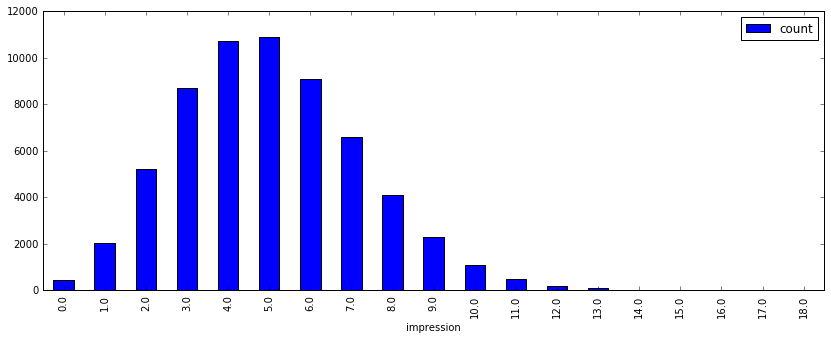

In [12]:
spark_histogram(clicksmappd, 'impression')

In [13]:
# massive outliers, will skew histogram buckets
no_out_df = clicksmappd.filter(clicksmappd['impression'] < 12)

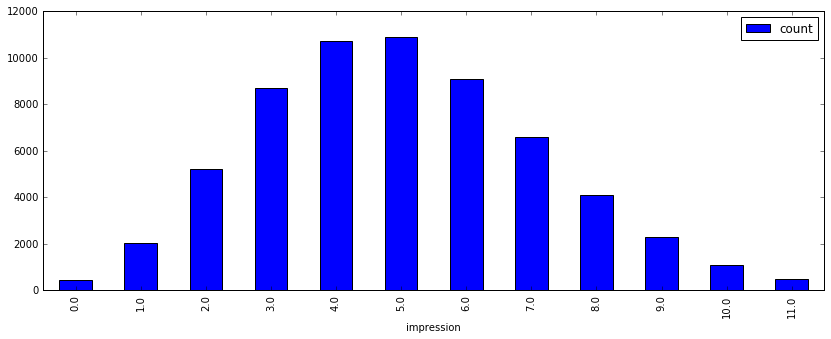

In [14]:
spark_histogram(no_out_df, 'impression')